<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/EDA_JH_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Data Analysis

(https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data) provides realtime information and counts cases of COVID-19 coronavirus in China, as well as around the world, including numbers of deaths, recovered patients, and countries affected

In this post, we provide sample Python code to pull data from JH and perform very basic data processing and basic analysis. 

In [0]:
#Import libraries we need
import  pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
import seaborn as sns

Functions to pull data and tranform data.

In [0]:
JH_Data_ROOT = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data"

#JH dataset get format changed on March 23. Old files are not updated. Using the following new files (2, instead of 3)
TS_File_Confirm    =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_confirmed_global.csv")
TS_File_Death      =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_deaths_global.csv")
#TS_File_Recovered  =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_19-covid-Recovered.csv")

Daily_File_ROOT =  os.path.join(JH_Data_ROOT, "csse_covid_19_daily_reports")
#File name will be in the format similar to 03-23-2020.csv

def read_JH_TS_file(filePath, asCumValue=True):
    df = pd.read_csv(filePath)
    df.rename(columns={'Province/State': 'State', 'Country/Region' : 'Country'}, inplace=True)
    df['State'] = df['State'].fillna("")
    colnames = df.columns
    if asCumValue == True:
       return (df)
    else:
       #prepare a numpy matrix as the placehold, initialized as 0
       difs = np.zeros((df.shape[0], df.shape[1]-5), dtype=int)
       for i in range(5, df.shape[1]):
           value = df.iloc[:, i] -  df.iloc[:, i-1]
           value[value <0] =0
           difs[:, i-5] = value

       difs = pd.DataFrame(difs, columns=colnames[5:])
       df_delta = pd.concat([df.iloc[:, :4], difs], axis=1)
       return (df_delta)

def melt_JH_TS(df, value_name):
    dfo = pd.melt(df, id_vars=['State',	'Country',	'Lat',	'Long'], var_name="Date", value_name=value_name)
    dfo['Date'] = dfo['Date'].astype('datetime64[ns]')
    dfo.sort_values(by=['Country', 'State',	 'Date'],  inplace=True)
    dfo = dfo.reset_index(drop=True)
    return (dfo)


def merge_confirm_death(TS_File_Confirm, TS_File_Death, asCumValue=True):
    Data_Confirm  = read_JH_TS_file(TS_File_Confirm, asCumValue)
    Data_Death    = read_JH_TS_file(TS_File_Death, asCumValue)
    #Data_Recovered= read_JH_TS_file(TS_File_Recovered, asCumValue)  #this file is not supported after March 23

    Data_Confirm   = melt_JH_TS(Data_Confirm, "Confirm")
    Data_Death     = melt_JH_TS(Data_Death, "Death")
    #Data_Recovered = melt_JH_TS(Data_Recovered, "Recovered")

    data = pd.merge(Data_Confirm, Data_Death[["Country", "State", "Date", "Death"]],  on=["Country", "State", "Date"],  how="inner")
    #data = pd.merge(data,     Data_Recovered[["Country", "State", "Date", "Recovered"]], on=["Country", "State", "Date"],  how="inner")
    data = data.sort_values(["Country", "State", "Date"])

    world_Confirm   = Data_Confirm.groupby(["Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    world_Death     = Data_Death.groupby(["Date"]).agg( Death =( "Death", np.sum)).reset_index()
    #world_Recovered = Data_Recovered.groupby(["Date"]).agg( Recovered =( "Recovered", np.sum)).reset_index()

    world_data = pd.merge(world_Confirm, world_Death,  on="Date",  how="inner")
    #world_data = pd.merge(world_data, world_Recovered, on="Date",  how="inner").sort_values(["Date"])

    country_Confirm     = Data_Confirm.groupby(["Country", "Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    country_Death       = Data_Death.groupby(["Country", "Date"]).agg( Death =( "Death", np.sum)).reset_index()
    #country_Recovered   = Data_Recovered.groupby(["Country", "Date"]).agg( Recovered =( "Recovered", np.sum)).reset_index()

    country_data = pd.merge(country_Confirm, country_Death,  on=["Country", "Date"],  how="inner")
    #country_data = pd.merge(country_data, country_Recovered, on=["Country", "Date"],  how="inner").sort_values(["Country", "Date"])

    return (world_data, country_data, data)


def data_after_X_cases(df, X, groupby_cols):
    newdf = df[df["Confirm"] >= X].copy()
    newdf["RowID_Group"] = newdf.groupby(groupby_cols).cumcount()+1
    return (newdf)

def get_countries_by_order_confirm(df, count=20):
   out = df.groupby("Country").tail(1)
   out = out.sort_values(by='Confirm', ascending=False)
   out = out[["Country", "Confirm"]].reset_index(drop=True).reset_index()
   return (out[out["index"] <= count].copy())


In [4]:
world_data, country_data, data = merge_confirm_death(TS_File_Confirm, TS_File_Death, asCumValue=True)
world_data_nc, country_data_nc, data_nc = merge_confirm_death(TS_File_Confirm, TS_File_Death, asCumValue=False)

country_data_10 = data_after_X_cases(df=country_data, X=10, groupby_cols= ["Country"])
country_data_10

country_data_100 = data_after_X_cases(df=country_data, X=100, groupby_cols= ["Country"])
country_data_100.head(10)

country_ranks_f10s = get_countries_by_order_confirm(country_data_100, 10)

country_data_100_10 = pd.merge(country_data_100, country_ranks_f10s[["Country", "index"]],  on=["Country"],  how="inner")
country_data_100_10.sort_values(by=["index", "Country", "Date"], inplace=True)

country_data_100_10 = pd.merge( country_data_100_10, country_data_nc,  on=["Country", "Date"], how="inner")
country_data_100_10.rename(columns={'Confirm_x': 'Confirm', 'Confirm_y' : 'Confirm_new', "Death_x": "Death", "Death_y": "Death"}, inplace=True)
  
country_data_100_10

,Country,Date,Confirm,Death,RowID_Group,index,Confirm_new,Death
0,China,2020-01-23,643,18,2,0,95,1
1,China,2020-01-24,920,26,3,0,277,8
2,China,2020-01-25,1406,42,4,0,486,16
3,China,2020-01-26,2075,56,5,0,669,14
4,China,2020-01-27,2877,82,6,0,802,26
...,...,...,...,...,...,...,...,...
314,Netherlands,2020-03-21,3640,137,16,10,637,30
315,Netherlands,2020-03-22,4217,180,17,10,577,43
316,Netherlands,2020-03-23,4764,214,18,10,547,34
317,Netherlands,2020-03-24,5580,277,19,10,816,63


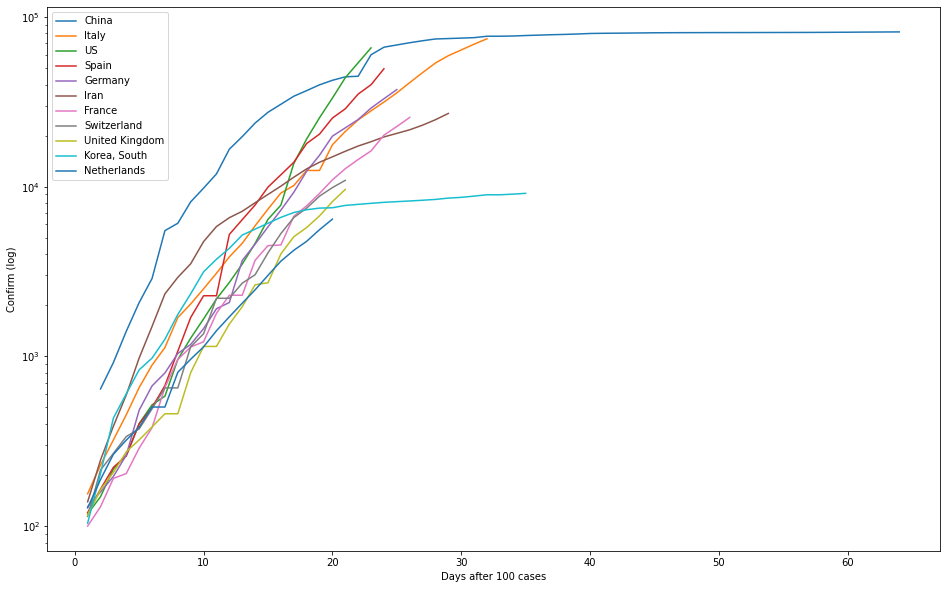

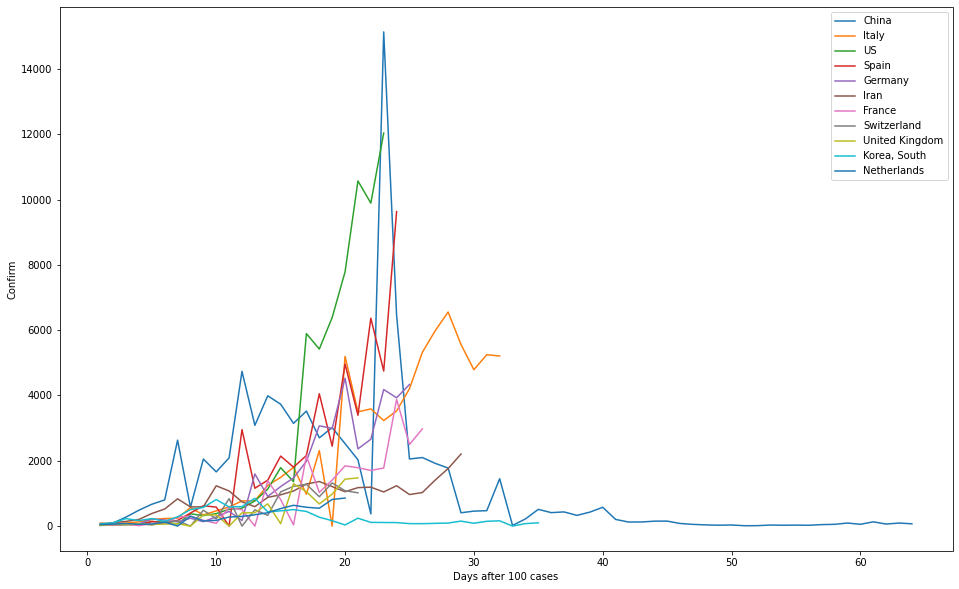

In [6]:
import matplotlib.pyplot as plt

def plot_growth(df, Y, usingLog=True):
  fig,ax = plt.subplots(figsize=(16, 10))

  for name in df.Country.unique():
      sel_df = df[df.Country==name]
      ax.plot(sel_df.RowID_Group, sel_df[Y],label=name)

  ax.set_xlabel("Days after 100 cases")
  if usingLog == True:
    ax.set_ylabel("Confirm (log)")
    ax.set_yscale('log')
  else:
    ax.set_ylabel("Confirm")
  ax.legend(loc='best')
  plt.show()

plot_growth(country_data_100_10, "Confirm", True)
plot_growth(country_data_100_10, "Confirm_new", False)

In [0]:
import plotly.express as px

df = country_data_100_10.query("RowID_Group<50")
fig = px.line(df, x="RowID_Group", y="Confirm", color="Country", log_y=True, title="Top 10 countries, days after 100 cases",
              labels = {"RowID_Group":"Days after 100 cases", "Confirm": "Confirm in log scale"},
              line_group="Country", hover_name="Country")
fig.show()

fig = px.line(df, x="RowID_Group", y="Confirm_new", color="Country", log_y=True, title="Top 10 countries, days after 100 cases",
              labels = {"RowID_Group":"Days after 100 cases", "Confirm_new": "Confirm New Cases"},
              line_group="Country", hover_name="Country")
fig.show()

Doing Modeling

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/covid-19.data.2020-03-24T031039.csv",low_memory=False)

In [0]:
df_us = df[ ((df.country == "United States") )] 

df_us